In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop forecasting on Eve mutant embryos

## Collect timing information

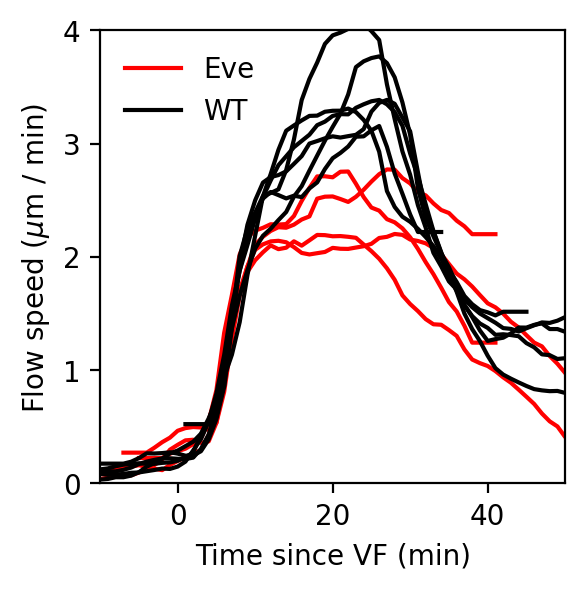

In [2]:
import glob
offsets_eve = {
    '202001151953': 5,
    '202001160041': 22,
    '202001171624': 20,
    '202001181115': 7,
}
offsets_wt = pd.read_csv('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/morphodynamic_offsets.csv', index_col='embryoID')
offsets_wt.index = offsets_wt.index.astype(str)
    
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(3, 3))
for i, folder in enumerate(glob.glob('Eve_Mutants/Sqh-GFP/2020*')):
    #print(folder)
    eId = os.path.basename(folder)
    v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
    t = np.arange(len(v0)) - offsets_eve[eId]

    if i == 0:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='red', label='Eve' )
    else:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='red')        

for i, folder in enumerate(glob.glob('../Public/Halo_Hetero_Twist[[]ey53[]]_Hetero/Sqh-GFP/2*')):
    #print(folder)
    eId = os.path.basename(folder)
    v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
    t  = np.arange(len(v0)) - offsets_wt.loc[eId][0]

    if i == 0:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='black', label='WT' )
    else:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='black')

        
ax.set_ylim([0, 4])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xlim([-10, 50])
ax.set_ylabel('Flow speed ($\mu$m / min)')
ax.set_xlabel('Time since VF (min)')
ax.legend(framealpha=0)

In [19]:
t = np.arange(-10, 41)

v_eve_avg = np.zeros(len(t))
v_eve_std = np.zeros(len(t))
v_wt_avg = np.zeros(len(t))
v_wt_std = np.zeros(len(t))

for i, ti in enumerate(t):
    vi = []
    for folder in glob.glob('Eve_Mutants/Sqh-GFP/2020*'):
        eId = os.path.basename(folder)
        v0 = np.linalg.norm(np.load(f'{folder}/velocity2D.npy', mmap_mode='r'), axis=1).mean(axis=(1,2))
        t0 = np.arange(len(v0)) - offsets_eve[eId]            
        vi.append(v0[np.abs(t0 - ti) < 1])
    vi = np.concatenate(vi)
    v_eve_avg[i] = np.mean(vi)
    v_eve_std[i] = np.std(vi)
    
    vi = []
    for folder in glob.glob('../Public/Halo_Hetero_Twist[[]ey53[]]_Hetero/Sqh-GFP/2*'):
        eId = os.path.basename(folder)
        v0 = np.linalg.norm(np.load(f'{folder}/velocity2D.npy', mmap_mode='r'), axis=1).mean(axis=(1,2))
        t0 = np.arange(len(v0)) - offsets_wt.loc[eId][0]            
        vi.append(v0[np.abs(t0 - ti) < 1])
    vi = np.concatenate(vi)
    v_wt_avg[i] = np.mean(vi)
    v_wt_std[i] = np.std(vi)

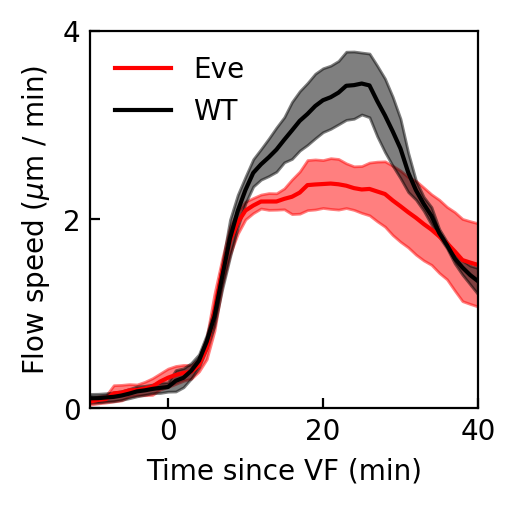

In [20]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2.5, 2.5))

ax.plot(t, v_eve_avg, color='red', label='Eve')
ax.fill_between(t, v_eve_avg-v_eve_std, v_eve_avg+v_eve_std, color='red', alpha=0.5)

ax.plot(t, v_wt_avg, color='black', label='WT')
ax.fill_between(t, v_wt_avg-v_wt_std, v_wt_avg+v_wt_std, color='black', alpha=0.5)
        
ax.set_ylim([0, 4])
ax.set_yticks([0, 2, 4])
ax.set_xlim([-10, 40])
ax.set_ylabel('Flow speed ($\mu$m / min)')
ax.set_xlabel('Time since VF (min)')
ax.tick_params(which='both', direction='in')
ax.legend(framealpha=0)

## Get cadherin initial condition

0.711, 1.6, 1.08, 0.208
0.743, 1.35, 1.05, 0.126
0.717, 1.56, 1.05, 0.178


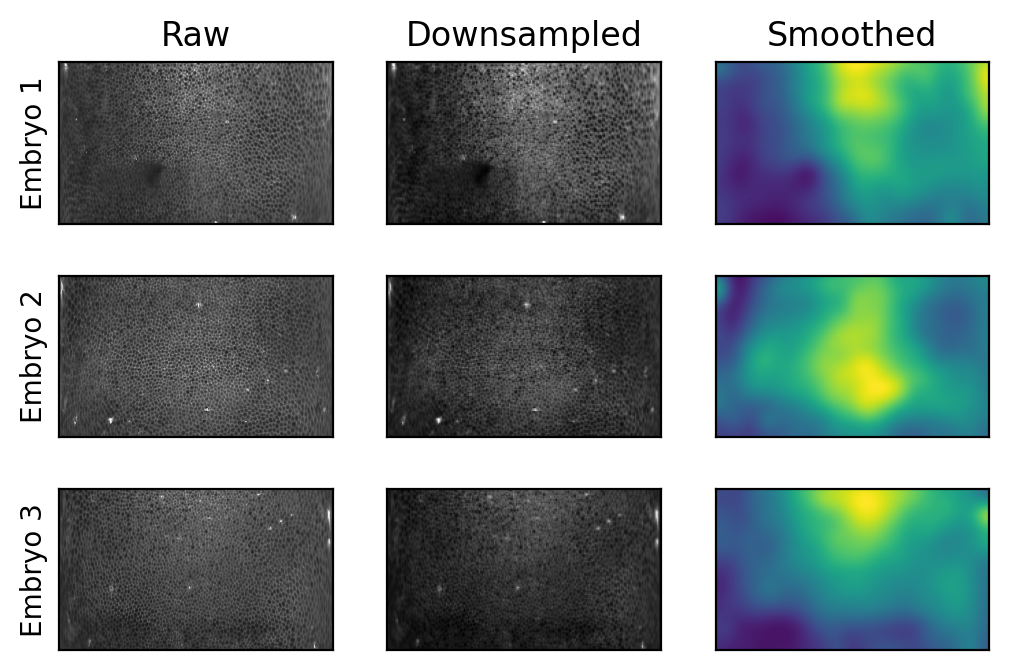

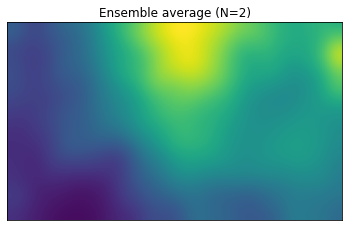

In [3]:
'''
E-cadherin is measured in Eve mutants so use an ensemble average
'''
from utils.plot_utils import *
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

fig, ax = plt.subplots(3, 3, dpi=200)

c0 = np.zeros([236, 200])

for i in range(3):
    raw = Image.open(f'Eve_Mutants/E-cadherin/{i+1}/MAX_Cyl1_2_000000_c1.tif')
    raw = np.array(raw)
    
    threshold = raw.mean() + 10*raw.std() #Fiduciary bead cutoff
    raw[raw > threshold] = threshold
    
    raw = raw.astype(float)
    raw /= np.median(raw)
    
    proc = resize(raw, [236, 200])
    smooth = gaussian_filter(proc, sigma=7)
    print(f'{smooth.min():.3g}, {smooth.max():.3g}, {smooth.mean():.3g}, {smooth.std():.3g}')

    color_2D(ax[i, 0], raw, cmap='Greys_r')
    color_2D(ax[i, 1], proc, cmap='Greys_r')
    color_2D(ax[i, 2], smooth, cmap='viridis')
    ax[i, 0].set_ylabel(f'Embryo {i+1}')
    
    if i == 1:
        continue
    c0 += 0.5 * smooth
    
ax[0, 0].set_title('Raw')
ax[0, 1].set_title('Downsampled')
ax[0, 2].set_title('Smoothed')

ax = plt.figure().gca()
color_2D(ax, c0, cmap='viridis')
ax.set_title('Ensemble average (N=2)')

np.save('Eve_Mutants/ensemble_c0', c0)

In [4]:
c0 = np.load('Eve_Mutants/ensemble_c0.npy')
c1 = np.load('Twist_Mutants/ensemble_c0.npy')

print(c0.min(), c1.min())
print(c0.max(), c1.max())
      
print(c0.mean(), c1.mean())
print(c0.std(), c1.std())

0.7257740532146955 0.8409516462331981
1.5615740509979774 1.4808744672095258
1.0647820936721044 1.0530597853657364
0.1877184320447953 0.14472339050397817


## Get ensemble-averaged myosin and flow

In [34]:
t = np.arange(-10, 21)

v_eve_avg = np.zeros([len(t), 2, 236, 200])
m_eve_avg = np.zeros([len(t), 2, 2, 236, 200])

for i, ti in enumerate(t):
    vi, mi = [], []
    for folder in glob.glob('Eve_Mutants/Sqh-GFP/2020*'):
        eId = os.path.basename(folder)
        v = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
        m = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
        
        t0 = np.arange(len(v)) - offsets_eve[eId]      
        mask = np.abs(t0 - ti) < 1
                        
        vi.append(v[mask])
        mi.append(m[mask])
    
    v_eve_avg[i] = np.mean(np.concatenate(vi, axis=0), axis=0)
    m_eve_avg[i] = np.mean(np.concatenate(mi, axis=0), axis=0)

np.save('Eve_Mutants/ensemble_v0', v_eve_avg)
np.save('Eve_Mutants/ensemble_m0', m_eve_avg)
np.save('Eve_Mutants/ensemble_t0', t)

print(v_eve_avg.shape, m_eve_avg.shape, t.shape)

(31, 2, 236, 200) (31, 2, 2, 236, 200) (31,)


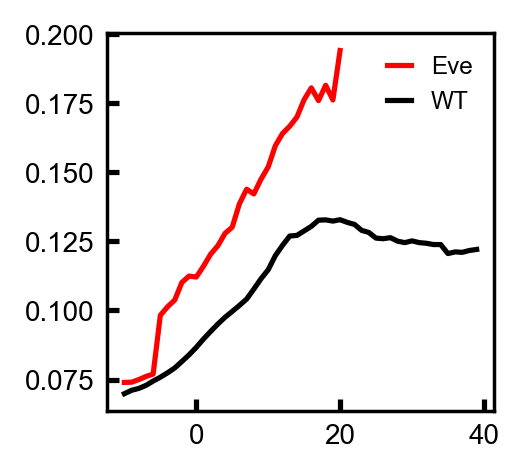

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

m0 = np.load('Eve_Mutants/ensemble_m0.npy')
t = np.load('Eve_Mutants/ensemble_t0.npy')
ax.plot(t, np.linalg.norm(m0, axis=(1, 2)).mean(axis=(1, 2)), color='red', label='Eve')

m0 = np.load('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/tensor2D.npy')
t = np.load('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/t.npy')
ax.plot(t, np.linalg.norm(m0, axis=(1, 2)).mean(axis=(1, 2)), color='black', label='WT')

ax.legend()

## Fly closed loop

Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


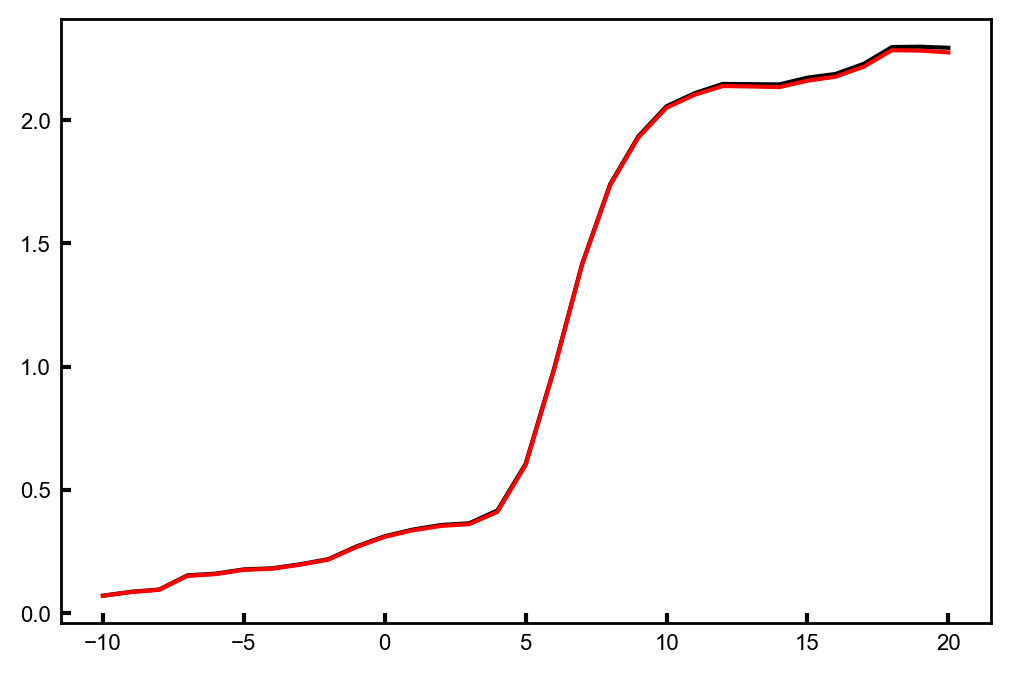

In [8]:
import torch
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../../tb_logs/May2023/forecasting_vae_v3.ckpt') #Works well with sigma = 3


vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, v, and time
folder = 'Eve_Mutants'
t0 = np.load(f'{folder}/ensemble_t0.npy')
v0 = np.load(f'{folder}/ensemble_v0.npy')
c0 = np.load(f'{folder}/ensemble_c0.npy')
m0 = np.load(f'{folder}/ensemble_m0.npy')

    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

from scipy.interpolate import interp1d
v_int = interp1d(t0, v0, axis=0)
def v_model(t, y):
    v = v_int(t.cpu().numpy())
    return torch.from_numpy(v).to(device)

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    c0.reshape([1, *c0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m1, c1, v1 = model.integrate(y0.to(device), t0)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(t0, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='black')
ax.plot(t0, np.linalg.norm(v1, axis=1).mean(axis=(1, 2)), color='red')

np.save(f'{folder}/forecasted_m', m1)
np.save(f'{folder}/forecasted_v', v1)

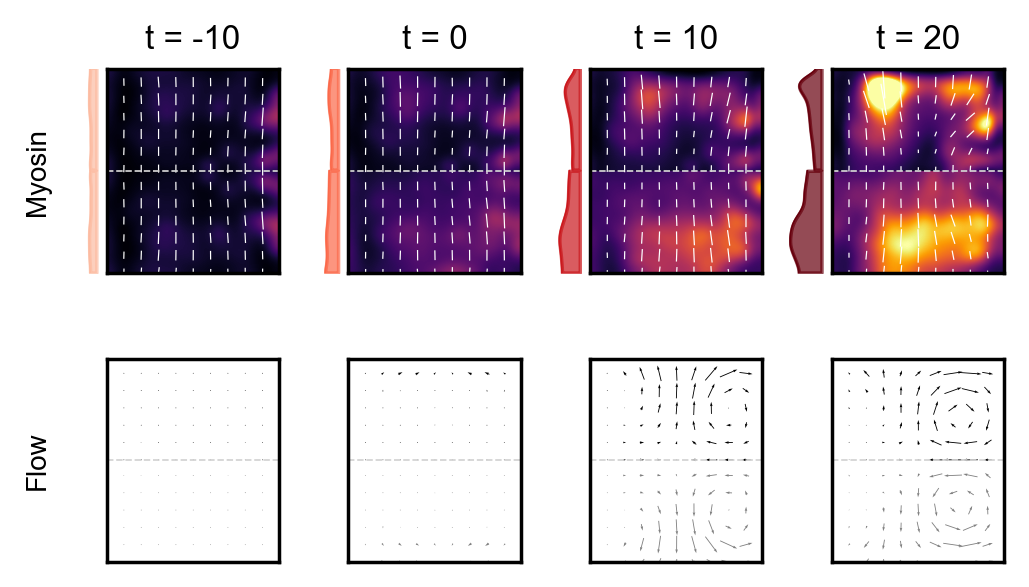

In [9]:
time = t0
mask = np.s_[..., 15:-15, 15:-15]

inputs  = [m1, v1]
targets = [m0, v0]
labels = ['Myosin', 'Flow']
colors = ['Reds', 'Greys']
dt = 10

N = int(np.ceil(len(time) / dt))
n_rows = 2
fig, ax = plt.subplots(n_rows, N, 
                       figsize=(N, n_rows*1.2),
                       constrained_layout=True)

vfc = 40
skip = 20
midpoint = 118
slc = np.s_[..., ::skip, ::skip]
ylim = [dv_min, dv_max]
xlim = [ap_min, ap_max]


top = np.s_[..., midpoint:, :]
bot = np.s_[..., :midpoint, :]
vwargs = dict(pivot='middle', width=0.005)

dv = np.linspace(dv_min, dv_min+(dv_max-dv_min)/2, midpoint)

mask_in = np.zeros([236, 200])
mask_tg = np.zeros([236, 200])
mask_in[top] = 1
mask_tg[bot] = 1

X = np.linspace(ap_min, ap_max, 200)
Y = np.linspace(dv_min, dv_max, 236)
Y, X = np.meshgrid(Y, X, indexing='ij')


for i, (label, z, z0) in enumerate(zip(labels, inputs, targets)):
    znorm = z0.reshape([z0.shape[0], -1, *z0.shape[-2:]])
    n_channels = znorm.shape[1]
    znorm = np.linalg.norm(znorm[mask], axis=1)[..., :-20] #ignore posterior pole
    kwargs = dict(vmin=np.min(znorm), vmax=np.max(znorm))

    axes = []
    cmap = plt.get_cmap(colors[i])
    for j in range(N):
        jj = dt * j
        if i == 0:
            ax[i, j].set_title(f't = {time[jj]:.0f}')

        color = cmap((time[jj] + 20) / (time.max() + 20))

        if n_channels == 1:
            color_2D(ax[i, j], z[jj, ::-1], alpha=mask_in, **kwargs)
            color_2D(ax[i, j], z0[jj], alpha=mask_tg, **kwargs)
        elif n_channels == 4:
            zj = z[jj, :, :, ::-1].copy()
            zj[0, 1] *= -1 #Because we're inverting it
            zj[1, 0] *= -1 #Because we're inverting it
            plot_tensor2D(ax[i, j], zj * np.sign(mask_in), alpha=mask_in, **kwargs)
            plot_tensor2D(ax[i, j], z0[jj] * np.sign(mask_tg), alpha=mask_tg, **kwargs)
        elif n_channels == 2:
            vwargs['scale'] = 5e1
            ax[i, j].quiver(X[bot][slc], Y[bot][slc],
                            z0[jj, 1][bot][slc], z0[jj, 0][bot][slc],
                            color='grey', **vwargs)
            ax[i, j].quiver(X[top][slc], Y[top][slc],
                            z[jj, 1, ::-1][top][slc], -z[jj, 0, ::-1][top][slc],
                            color='black', **vwargs)

        ax[i, j].set(xlim=xlim, ylim=ylim, xticks=[], yticks=[], aspect=1)
        ax[i, j].axhline(dv_min + 0.5*(dv_max-dv_min), lw=0.5, color='lightgrey', linestyle='--')
        
        if i == n_rows - 1:
            continue
            
        cut = get_cut(z[jj, ..., ::-1, :])
        cut0 = get_cut(z0[jj])

        cut = cut[midpoint:]
        cut0 = cut0[:midpoint]
        ax_Y = ax[i, j].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[i, j])
        ax_Y.plot(cut, dv+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, dv, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv, 0, cut0, color=color, alpha=0.7)
        axes.append(ax_Y)
        
        for axis in axes:
            xl = axes[-1].get_xlim()
            if label == 'Cadherin':
                axis.set_xlim([xl[0] + 0.4 * np.ptp(xl), xl[1]]) #Emphasize gradient over baseline
            else:
                axis.set_xlim(xl)
            axis.invert_xaxis()
            axis.axis('off')

    ax[i, 0].set_ylabel(label, labelpad=16)

#plt.savefig(f'Eve_Mutants/forecasting_{eId}.png', bbox_inches='tight')
#plt.savefig('Eve_Mutants/forecasting_ensemble.png', bbox_inches='tight')